**Solution on Basic Prediction Models**

BAS 474

Charles Liu

In [ ]:
library(regclass)
library(caret)
library(glmnet)
library(pROC)

##suggest_transformation takes a vector of numerical values (x) and a sequence of numbers (powers).
##The function calculates a robust measure of skewness when x is raised to the power given in powers.
##(When the power equals 0, the logarithm is used instead).  The function returns the power associated
##with the skewness closest to 0 (most symmetric), or "log10" if the logarithm transformation looked best.
#Returns NULL if x is categorical
##Note 1:  if x has negative values, only positive values of powers are attempted
##Note 2:  optional argument add will add that value to each value before making transformations
suggest_transformation <- function(x,powers=seq(from=0,to=3,by=0.5),add=0) {
  if( !(class(x) %in% c("numeric","integer") ) ) { return(NULL) }
  require(robustbase)
  if(add!=0) { x <- x + add }
  if(min(x)<=0) { powers <- powers[which(powers>0)] }
  skewnesses <- rep(0,length(powers))
  for (p in powers) {
    if(p==0) { x.trans <- log10(x) } else { x.trans <- x^p }
    skewnesses[which(powers==p)] <- mc(x.trans)
  }
  best.p <- powers[which.min(skewnesses)]
  if(best.p==0) { return("log10")} else { return(best.p) }
}

# Numerical Prediction

In the `CENSUS` data from `regclass`, the goal is predict `ResponseRate`, the percentage (0-100) of households in an area that mails back the census form.  The distribution of `ResponseRate` is roughly symmetric (as you can see from running `hist(CENSUS$ResponseRate)`), so we can use it as our `y` variable without further modification.

The predictor variables (percent of households with different ethnicities, ages, type of households, incomes, etc.) are for the most part symmetric, or odd-looking enough that no transformation would help (e.g. `hist(CENSUS$Rural)`.  One exception is `hist(CENSUS$Area)`, so we'll have to find a transformation for it (the rest we will leave alone).

a.  Run `suggest_transformation` (you'll need to read in the function using the code in the first chunk) on `CENSUS$Area`, then replace the values in the `Area` column with the suggested transformation.  Verify that `summary` of `CENSUS$Area` passes the sanity check.  Note:  be sure to not re-transform this column again (you'll get `Warning message:  NaNs produced if you do`).

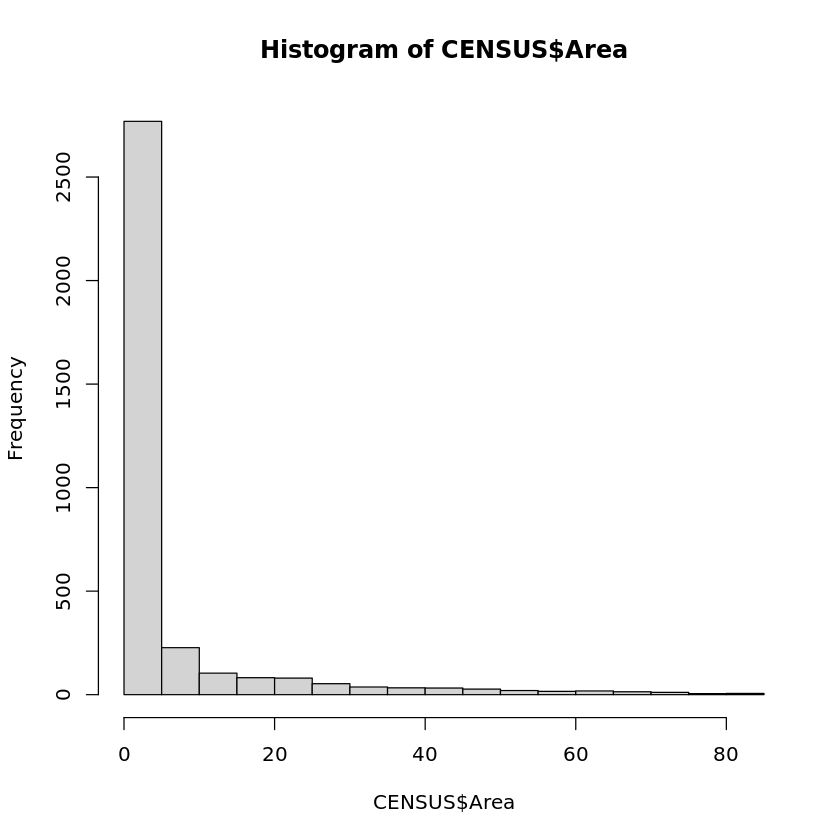

In [2]:
data(CENSUS)
hist(CENSUS$Area)

In [3]:
suggest_transformation(CENSUS$Area)

Loading required package: robustbase



[1] "log10"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.22185 -0.72354 -0.31967 -0.09506  0.49796  1.91960 

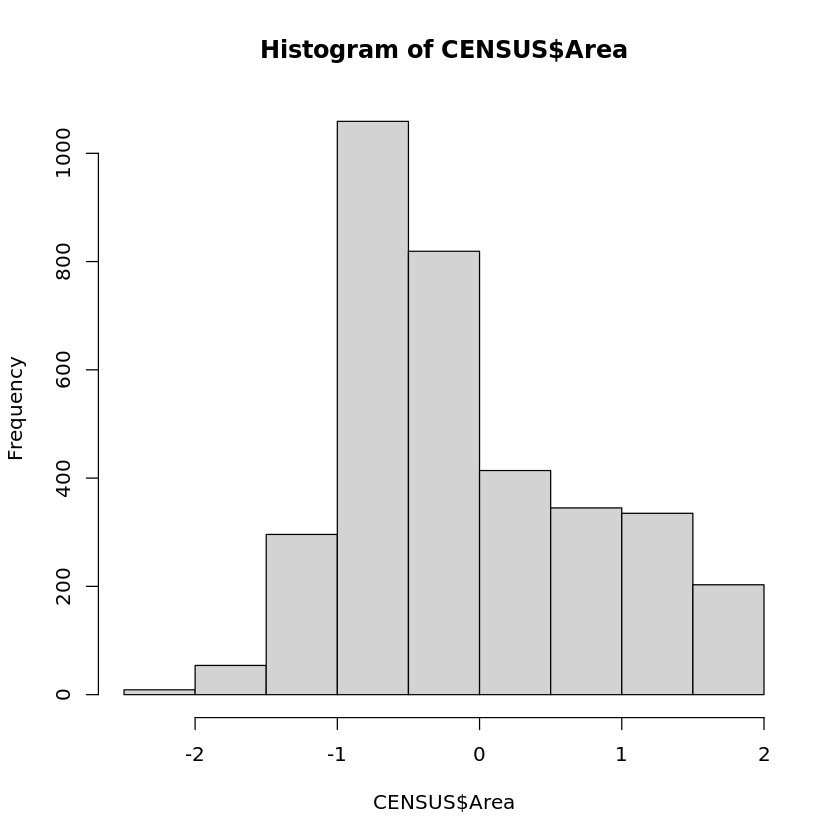

In [4]:
CENSUS$Area <- log10(CENSUS$Area)
hist(CENSUS$Area)
summary(CENSUS$Area)
#    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.
#-2.22185 -0.72354 -0.31967 -0.09506  0.49796  1.91960


b.  There may be predictors with zero variance or near-zero variance (not enough diversity in values to contribute much information about variation in response rates).  The first four lines of code explores whether there are such predictors, while the remaining code removes them.  Since `CENSUS` is being overwritten, this change is permanent.



In [5]:
near.zero.variance <- nearZeroVar(CENSUS)
near.zero.variance

[1] 32 33 34 35

In [6]:
dim(CENSUS)
CENSUS <- CENSUS[,-near.zero.variance ] #Get rid of these near-zero variance predictors
dim(CENSUS)

[1] 3534   39

[1] 3534   35

c.  There may be predictors that are highly correlated (and therefore give more or less redundant information).
Verify that there are two columns that are highly correlated with "something else" in the data (it turns out that `HomeownerHH` is highly correlated with `RentingHH` while `NumHH` is highly correlated with `NumUnits`).  Remove the highly correlated columns (this takes out `HomeownerHH` and `NumHH`, but leaves `RentingHH` and `NumUnits`).

In [7]:
cor.between.columns <- cor(CENSUS)
highlycorrelated <- findCorrelation( cor.between.columns , cutoff = .90)
highlycorrelated
names(CENSUS)[highlycorrelated]

[1] 30 33

[1] "HomeownerHH" "NumHH"

In [8]:
head(sort(abs(cor.between.columns['HomeownerHH',]), decreasing=TRUE)) #What's so correlated with HomeownerHH?
head(sort(abs(cor.between.columns['NumHH',]), decreasing=TRUE)) #What's so correlated with NumHH?

HomeownerHH    RentingHH    MarriedHH    RelatedHH   NoSpouseHH ResponseRate 
   1.0000000    0.9318275    0.8457687    0.7226054    0.7151232    0.6454007

NumHH   NumUnits Population       Area     Whites   FemaleHH 
 1.0000000  0.9907350  0.8667410  0.2324133  0.1812372  0.1705303

In [9]:
dim(CENSUS)
CENSUS <- CENSUS[, -highlycorrelated]
dim(CENSUS)

[1] 3534   35

[1] 3534   33


d1.  There may be "linear combinations" of predictors.  In fact, `Urban`, `Suburban`, and `Rural` should add up to 100 (it's the fractions of people living in each of these 3 settings per block group).  If they do, they represent a linear combination.  They might not because of rounding, but it's worth exploring.  Verify that there are no linear combinations.



In [10]:
comboInfo <- findLinearCombos(CENSUS)
comboInfo$remove  #in this case, didn't find any!

NULL


d2.  Unfortunately `findLinearCombos` doesn't always find columns that are "almost" linear combinations of each other.  In this case, `Urban` + `Suburban` + `Rural` add up to 100 (when it doesn't, it's due to rounding issues in the original data), but `findLinearCombos` misses this.  Show this is the case by running `summary(CENSUS$Urban+CENSUS$Suburban+CENSUS$Rural)`, then `NULL` out `Suburban` column.  Also, `NULL` out the `AgeLess5` column (the sum over all age columns is also basically 100) and the `Other` column (the sum over all ethnicity columns is also basically 100).



In [11]:
summary(CENSUS$Urban+CENSUS$Suburban+CENSUS$Rural)
dim(CENSUS)
CENSUS$Suburban <- NULL
CENSUS$AgeLess5 <- NULL
CENSUS$Other <- NULL
dim(CENSUS)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   100.0   100.0   100.0   100.0   100.1 

[1] 3534   33

[1] 3534   30

## Basic Models with Cross Validation



e.  After performing validation/integrity checks, doing transformations, and removing unnecessary columns, the next step when building a predictive model is to split the data into training and holdout samples.  Then, determine how the generalization error is to be estimated.

The following code generates the `train.rows` vector that is to be used to split the data into 60% training and 40% holdout.  Keep this chunk in mind, you'll be writing something VERY similar for nearly every problem we do (just have to change the 0.6 to reflect the fraction in the training sample, the `CENSUS` to reflect the name of the new dataset, and potentially the `474` if I specifically ask you to prep the random number stream differently).  Pass the sanity check with `head`.




In [12]:
dim(CENSUS) #should be 3534 30 going into it with the unnecessary columns removed
set.seed(474)
train.rows <- sample(1:nrow(CENSUS), 0.6*nrow(CENSUS))
TRAIN <- CENSUS[train.rows, ]
HOLDOUT <- CENSUS[-train.rows, ]
head(TRAIN[,1:5])

[1] 3534   30

,ResponseRate,Area,Urban,Rural,Male
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
854,89.8,1.6577154,0,100,50.1
2649,84.8,0.9508028,0,100,49.9
405,87.7,1.5798750,0,100,50.2
3463,88.3,-0.6968039,100,0,50.3
2479,73.8,-0.4559320,100,0,46.7
1452,91.4,-0.6307841,100,0,49.1


f.  It's model-fitting time, starting with vanilla linear regression.

To be consistent with models, we will add the argument   `preProc=c("center", "scale")` (we aren't doing descriptive analytics, so no need to interpret coefficients).  Find the estimated generalization error and its standard deviation.

Note that `trControl` has been setup to estimate the generalization errors with vanilla 5-fold cross validation.

In [13]:
trControl <- trainControl(method="cv",number=5)
set.seed(474)
REG <- train(ResponseRate~., data=TRAIN, method='glm',
             trControl=trControl, preProc=c("center", "scale") )
REG
REG$results

Generalized Linear Model 

2120 samples
  29 predictor

Pre-processing: centered (29), scaled (29) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1697, 1695, 1698, 1695, 1695 
Resampling results:

  RMSE      Rsquared  MAE     
  4.781627  0.600186  3.637545


,parameter,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,4.781627,0.600186,3.637545,0.246895,0.007635384,0.1387442


g.  Let's do regularized regression, which chooses coefficients in a manner that's more conducive for predictive analytics (and which allows weigh the tradeoff between the bias and variance of the model).  We will set up the "grid" of tuning parameters to consider `alpha` along the sequence 0, 0.5, 1.00 and `lambda` of 10 raised to the power of -4, -3.5, -3, ..., -1.5, -1.

* Print to the screen the contents of the tuning grid so you can see all combinations of parameters we are auditioning
* Run `train`, then plot the object created by `train` so you can see how the estimated generalization error varies with the two tuning parameters.  Report the "best model's" estimated generalization error and its SD.

glmnet 

2120 samples
  29 predictor

Pre-processing: centered (29), scaled (29) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1697, 1695, 1698, 1695, 1695 
Resampling results across tuning parameters:

  alpha  lambda        RMSE      Rsquared   MAE     
  0.0    0.0001000000  4.829524  0.5918485  3.671467
  0.0    0.0003162278  4.829524  0.5918485  3.671467
  0.0    0.0010000000  4.829524  0.5918485  3.671467
  0.0    0.0031622777  4.829524  0.5918485  3.671467
  0.0    0.0100000000  4.829524  0.5918485  3.671467
  0.0    0.0316227766  4.829524  0.5918485  3.671467
  0.0    0.1000000000  4.829524  0.5918485  3.671467
  0.5    0.0001000000  4.790498  0.5986514  3.635869
  0.5    0.0003162278  4.790498  0.5986514  3.635869
  0.5    0.0010000000  4.790504  0.5986498  3.635858
  0.5    0.0031622777  4.791234  0.5984843  3.635920
  0.5    0.0100000000  4.793222  0.5980587  3.635950
  0.5    0.0316227766  4.812709  0.5947021  3.650207
  0.5    0.1000000000  4.827900  0.59

,alpha,lambda
,<dbl>,<dbl>
9,0.5,0.0003162278


,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,0.5,0.0003162278,4.790498,0.5986514,3.635869,0.2354052,0.008119388,0.1255351


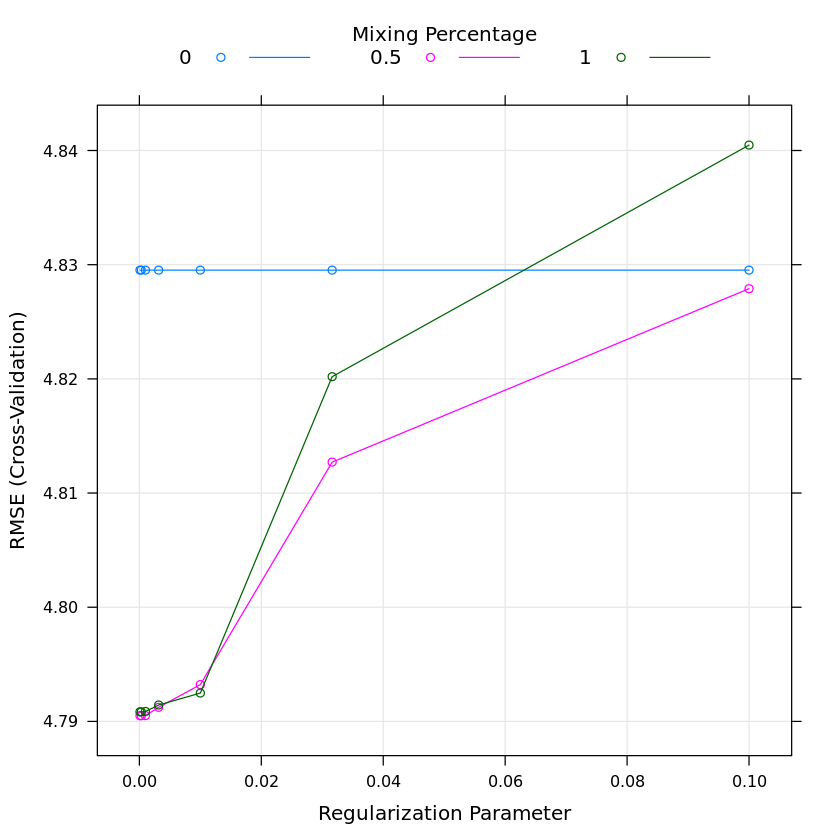

In [14]:
tuneGrid <- expand.grid(alpha = seq(0,1,.5), lambda = 10^seq(-4,-1,.5))
set.seed(474)
GLMnet <- train(ResponseRate~.,data=TRAIN, method='glmnet',
                tuneGrid=tuneGrid, trControl=trControl, preProc = c("center", "scale"))
GLMnet
plot(GLMnet)
GLMnet$bestTune #Gives best parameters
GLMnet$results[rownames(GLMnet$bestTune),]  #Just the row with the optimal choice of tuning parameter

h.  So what's the verdict?  Which model should you select, or do we have a choice according to the one standard deviation rule?

In [15]:
abs(4.781627 - 4.790498)/max(0.246895, 0.2354052)

[1] 0.03593025

**Response:** The vanilla linear regression model happens to have the lowest error, but regularized regression model has an error that's well-within 1 SD, so we could choose between these two models.


i.  With the final model selected, we can check its performance on the holdout sample using the `postResample` command.  Is the actual error on this holdout sample about what was expected?  Any signs of overfitting (actual error more than 10% worse than what was expected)?



In [16]:
postResample(predict(REG,newdata=HOLDOUT), HOLDOUT$ResponseRate)
postResample(predict(GLMnet,newdata=HOLDOUT), HOLDOUT$ResponseRate)

RMSE  Rsquared       MAE 
4.9201620 0.5578568 3.5849020

RMSE  Rsquared       MAE 
4.9339978 0.5553929 3.6022702

**Response:**
The regularized regression happens to perform worse on the holdout.
The errors for both models on the holdout are a bit worse (higher) than expected.
But the changes are less than 10%, so the models are not overfit!

j.  Run `varImp` to see the most important varibales in the two models. Usually the variable importantce is different in different models, but do you see some variables important for both models?

In [17]:
varImp(REG)

glm variable importance

  only 20 most important variables shown (out of 29)

                    Overall
RentingHH           100.000
MarriedHH            65.520
MobileHomeUnits      53.049
RelatedHH            47.932
NoSpouseHH           44.255
MedianHHIncomeCity   35.192
Age18to24            28.435
Whites               27.118
Hispanics            26.675
Blacks               26.297
Asians               25.977
Hawaiians            17.598
NativeAmericans      16.757
FemaleHH             16.455
logMedianHouseValue  15.164
Rural                13.749
AloneHH              13.650
Male                 11.762
Age65plus             9.377
Population            8.476

In [18]:
varImp(GLMnet)

glmnet variable importance

  only 20 most important variables shown (out of 29)

                    Overall
MarriedHH           100.000
RelatedHH            58.888
NoSpouseHH           32.834
RentingHH            24.661
Whites               12.887
FemaleHH              9.422
Age18to24             9.410
MedianHHIncomeCity    8.291
MobileHomeUnits       7.799
AloneHH               6.743
Population            6.556
Age65plus             6.486
NumUnits              4.995
Hispanics             4.052
logMedianHouseValue   3.952
NativeAmericans       3.792
WithKidHH             3.647
Rural                 3.524
Age25to44             3.488
Age45to64             2.961

k.  If you go and don't NULL out any column, you'll find that `glmnet` can automatically eliminate some redundant variables.
Amazing? Please review our discussions on regularized models for an explanation.

In [19]:
data(CENSUS)
CENSUS$Area <- log10(CENSUS$Area)
set.seed(474)
train.rows <- sample(1:nrow(CENSUS),0.6*nrow(CENSUS))
TRAIN <- CENSUS[train.rows,]
HOLDOUT <- CENSUS[-train.rows,]
set.seed(474)
GLMnet <- train(ResponseRate~., data=TRAIN, method='glmnet',
                tuneGrid=tuneGrid, trControl=trControl, preProc = c("center", "scale"))
GLMnet$finalModel$xNames[ which( as.numeric(coef(GLMnet$finalModel,GLMnet$bestTune$lambda)) == 0 ) - 1 ]

[1] "Suburban"  "Hispanics" "RentingHH"

# Classification

Let's use the `EX7.CATALOG` data and predict whether a customer will make a purchase from a catalog in the next quarter based on prior purchase history and information about the number of catalogs that were received.

a.  The first step is data validation and making sure all values make sense (they do here).  Then, we should try to symmetrize the predictors.  One issue with the `QuartersWithPurchase`, `PercentQuartersWithPurchase`, and `DaysSinceLastPurchase` predictors is that they have 0s (and we can't take the logarithm of 0 or a negative number).  In `suggest_transformation`, use the additional argument `add=1` to effectively consider transformations after adding 1 to each value.

In [20]:
data(EX7.CATALOG)

suggest_transformation(EX7.CATALOG$QuartersWithPurchase,add=1)
EX7.CATALOG$QuartersWithPurchase <- log10( EX7.CATALOG$QuartersWithPurchase + 1 )

suggest_transformation(EX7.CATALOG$PercentQuartersWithPurchase,add=1)
EX7.CATALOG$PercentQuartersWithPurchase <- log10( EX7.CATALOG$PercentQuartersWithPurchase + 1 )

suggest_transformation(EX7.CATALOG$CatalogsReceived)
EX7.CATALOG$CatalogsReceived <- log10(EX7.CATALOG$CatalogsReceived)

suggest_transformation(EX7.CATALOG$DaysSinceLastPurchase,add=1)
EX7.CATALOG$DaysSinceLastPurchase <- log10( EX7.CATALOG$DaysSinceLastPurchase + 1 )

suggest_transformation(EX7.CATALOG$AvgOrderSize)
EX7.CATALOG$AvgOrderSize <- log10(EX7.CATALOG$AvgOrderSize)

suggest_transformation(EX7.CATALOG$LifetimeOrder)
EX7.CATALOG$LifetimeOrder <- log10(EX7.CATALOG$LifetimeOrder)

summary(EX7.CATALOG)
#  Buy       QuartersWithPurchase PercentQuartersWithPurchase CatalogsReceived DaysSinceLastPurchase  AvgOrderSize    LifetimeOrder
# No :1802   Min.   :0.0000       Min.   :0.0000              Min.   :0.0000   Min.   :0.000         Min.   :0.0000   Min.   :0.0000
# Yes:2198   1st Qu.:0.0000       1st Qu.:0.0000              1st Qu.:0.3010   1st Qu.:2.387         1st Qu.:0.1461   1st Qu.:0.0000
#            Median :0.3010       Median :1.1761              Median :0.4771   Median :2.757         Median :0.3010   Median :0.4771
#            Mean   :0.2815       Mean   :0.9343              Mean   :0.5117   Mean   :2.677         Mean   :0.3526   Mean   :0.5104
#            3rd Qu.:0.4771       3rd Qu.:1.5315              3rd Qu.:0.7782   3rd Qu.:3.126         3rd Qu.:0.5229   3rd Qu.:0.8451
#            Max.   :1.0000       Max.   :2.0043              Max.   :1.3424   Max.   :3.895         Max.   :1.3424   Max.   :1.9395

[1] "log10"

[1] "log10"

[1] "log10"

[1] "log10"

[1] "log10"

[1] "log10"

  Buy       QuartersWithPurchase PercentQuartersWithPurchase CatalogsReceived
 No :1802   Min.   :0.0000       Min.   :0.0000              Min.   :0.0000  
 Yes:2198   1st Qu.:0.0000       1st Qu.:0.0000              1st Qu.:0.3010  
            Median :0.3010       Median :1.1761              Median :0.4771  
            Mean   :0.2815       Mean   :0.9343              Mean   :0.5117  
            3rd Qu.:0.4771       3rd Qu.:1.5315              3rd Qu.:0.7782  
            Max.   :1.0000       Max.   :2.0043              Max.   :1.3424  
 DaysSinceLastPurchase  AvgOrderSize    LifetimeOrder   
 Min.   :0.000         Min.   :0.0000   Min.   :0.0000  
 1st Qu.:2.387         1st Qu.:0.1461   1st Qu.:0.0000  
 Median :2.757         Median :0.3010   Median :0.4771  
 Mean   :2.677         Mean   :0.3526   Mean   :0.5104  
 3rd Qu.:3.126         3rd Qu.:0.5229   3rd Qu.:0.8451  
 Max.   :3.895         Max.   :1.3424   Max.   :1.9395  


b.  There may be predictors with zero variance or near-zero variance (not enough diversity in values to contribute much information about variation in response rates).  The first two lines of code shows that there are no such predictors.  There may be predictors that are highly correlated (and therefore give more or less redundant information regarding Buy).  But none exist here.  There may be "linear combinations" of predictors.  But the analysis shows there are not!  We can proceed without further modification.



In [21]:
infodensity <- nearZeroVar(EX7.CATALOG, saveMetrics= TRUE)
infodensity[infodensity$nzv,][1:5,]  #nothing to see here
highlycorrelated <- findCorrelation( cor(EX7.CATALOG[,-1]) , cutoff = .90) #all but 1st column, which is Buy
highlycorrelated #nothing to see
comboInfo <- findLinearCombos(EX7.CATALOG[,-1])
comboInfo$remove  #nothing

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA
NA.2,NA,NA,NA,NA
NA.3,NA,NA,NA,NA
NA.4,NA,NA,NA,NA


integer(0)

NULL



c.  After performing validation/integrity checks, doing transformations, and removing unnecessary columns, the next step when building a predictive model is to split the data into training and holdout samples.  Then, determine how the generalization error is to be estimated.

The following code generates the `train.rows` vector that is to be used to split the data into 65% training and 35% holdout, and `fitControl` has been setup to estimate the generalization errors with vanilla 5-fold crossvalidation (no repeats).  Keep this chunk in mind, you'll be writing something VERY similar for every problem we do (just have to change the 0.6 to reflect the fraction in the training sample, the `EX7.CATALOG` to reflect the name of the new dataset, and potentially the `474` if I specifically ask you to prep the random number stream differently).  Pass the sanity check with `head` and find the accuracy of the naive model.




In [22]:
set.seed(474); train.rows <- sample(1:nrow(EX7.CATALOG),0.65*nrow(EX7.CATALOG))
TRAIN <- EX7.CATALOG[train.rows,]; HOLDOUT <- EX7.CATALOG[-train.rows,]
fitControl <- trainControl(method="cv",number=5,classProbs=TRUE)   #This makes it so ACCURACY is the chosen metric
                                                                   #If AUC was wanted instead, we'd need to add the additional argument
                                                                   #summaryFunction = twoClassSummary
head(TRAIN[,1:5])
mean(TRAIN$Buy=="Yes")    #Majority on TRAIN is Yes

,Buy,QuartersWithPurchase,PercentQuartersWithPurchase,CatalogsReceived,DaysSinceLastPurchase
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
854,No,0.30103,1.176091,0.7781513,3.241048
3949,Yes,0.60206,1.322219,1.0000000,1.447158
3542,No,0.30103,1.000000,0.4771213,2.989895
2649,No,0.60206,1.380211,0.6020600,3.010300
405,Yes,0.60206,1.230449,0.7781513,2.448706
3463,No,0.60206,1.643453,0.9030900,2.161368


[1] 0.5511538

**Response:** The anticipated accuracy of the naive model is 55% (a very low bar)

d.  It's model-fitting time, starting with vanilla logistic regression.  To be consistent with how we treat the data between models, we will add the argument   `preProc=c("center", "scale")` (we aren't doing descriptive analytics, so no need to interpret coefficients).  Find the estimated accuracy and its standard deviation.

In [23]:
set.seed(474); REG <- train(Buy~.,data=TRAIN,method='glm',
                               trControl=fitControl,preProc=c("center", "scale") )
REG$results

,parameter,Accuracy,Kappa,AccuracySD,KappaSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.6361422,0.2606006,0.02269171,0.04359381


e.  Let's do regularized regression, which chooses coefficients in a manner that's more conducive for predictive analytics (and which allows weigh the tradeoff between the bias and variance of the model).  We will set up the "grid" of tuning parameters to consider `alpha` along the sequence 0, 0.5, 1.00 and `lambda` of 10 raised to the power of -4, -3.5, -3, ..., -1.5, -1.  Print out the contents of the grid to the screen so you can see how many combinations we are considering.  Plot the object created by `train` so you can see how the estimated generalization error varies with the two tuning parameters.  Report the estimated generalization error and its SD.

alpha,lambda
<dbl>,<dbl>
0.0,0.0001000000
0.5,0.0001000000
1.0,0.0001000000
0.0,0.0003162278
0.5,0.0003162278
1.0,0.0003162278
0.0,0.0010000000
0.5,0.0010000000
1.0,0.0010000000


,alpha,lambda
,<dbl>,<dbl>
18,1,0.003162278


,alpha,lambda,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,1,0.003162278,0.6372983,0.2616028,0.02191228,0.04179237


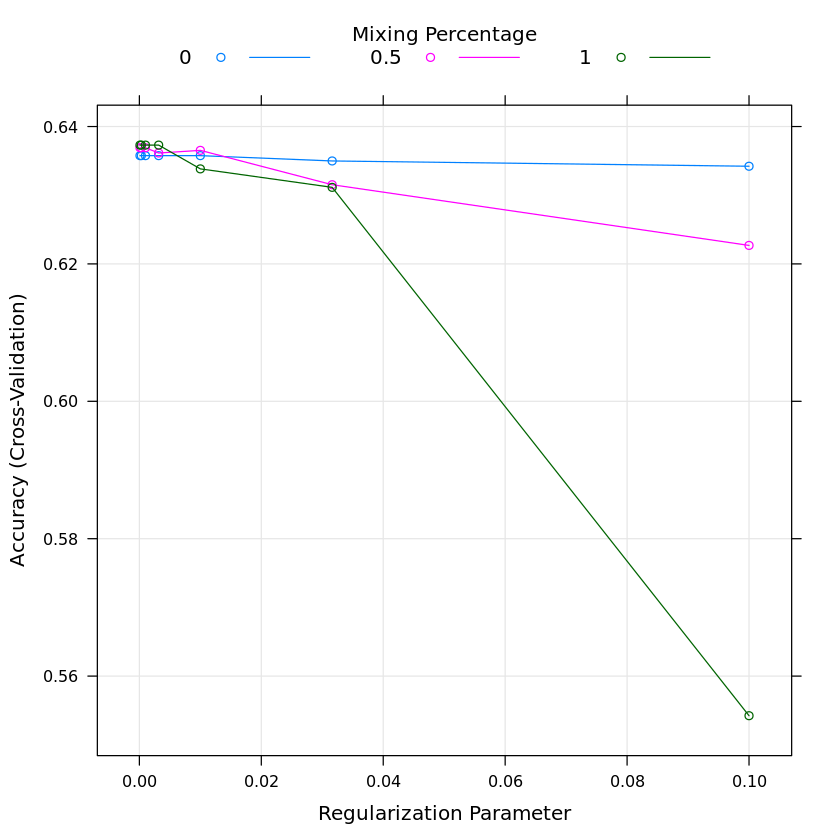

In [24]:
glmnetGrid <- expand.grid(alpha = seq(0,1,.5),lambda = 10^seq(-4,-1,by=.5))
glmnetGrid
set.seed(474); GLMnet <- train(Buy~.,data=TRAIN,method='glmnet', tuneGrid=glmnetGrid,
                               trControl=fitControl, preProc = c("center", "scale"))
plot(GLMnet)
GLMnet$bestTune #Gives best parameters
GLMnet$results[rownames(GLMnet$bestTune),]  #Just the row with the optimal choice of tuning parameter

f.  Let's do k-nearest neighbors (predicted probability of a new individual is found by letting nearest neighbors have a vote, where "nearest" is judged based on the Euclidean distance).  Set up the search grid so it considers values of `k` from 1 to 40.  Plot the object created by `train` so you can see how the estimated generalization error varies with the number of neighbors.  Report the estimated generalization error and its SD.

,k
,<int>
39,39


,k,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
39,39,0.62114,0.2338122,0.02723133,0.05330878


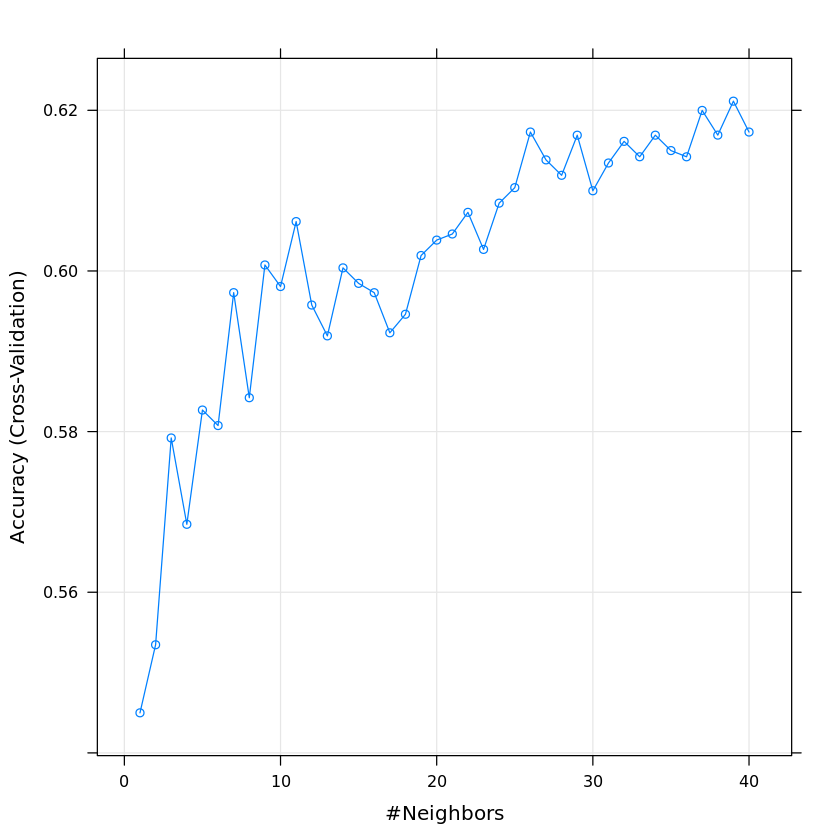

In [25]:
knnGrid <- expand.grid(k=1:40)
set.seed(474); KNN <- train(Buy~.,data=TRAIN,method='knn', tuneGrid=knnGrid,
                               trControl=fitControl, preProc = c("center", "scale"))
plot(KNN)
KNN$bestTune #Gives best parameters
KNN$results[rownames(KNN$bestTune),]  #Just the row with the optimal choice of tuning parameter

g.  So what's the verdict?  Which model should you select, or is there a choice?  Any model outright eliminated from consideration?

In [26]:
(0.6372983 - 0.62114)/0.02723133  #highest accuracy found vs. lowest accuracy found divided by larger of two SDs

[1] 0.5933717

**Response:** All models have accuracies within 1 SD of each other, so any of them should be "fine".

h.  With the final model selected, we can check its performance on the holdout sample using the `postResample` command.  Is the actual error on this holdout sample about what was expected?  Any signs of overfitting?  Do the models beat the naive model?  Remember, we never use performance on the holdout to change our mind over what model to use.

In [27]:
postResample(predict(REG,newdata=HOLDOUT),HOLDOUT$Buy)
postResample(predict(GLMnet,newdata=HOLDOUT),HOLDOUT$Buy)
set.seed(474); postResample(predict(KNN,newdata=HOLDOUT),HOLDOUT$Buy)
mean(HOLDOUT$Buy=="Yes")  #Naive

Accuracy     Kappa 
0.6207143 0.2297810

Accuracy     Kappa 
0.6271429 0.2410979

Accuracy     Kappa 
0.6121429 0.2157550

[1] 0.5464286

**Response:**  The `glmnet` happens to perform best on the holdout (KNN looks not as good).

The model is not overfit (it would be if the actual accuracy on the holdout is 10% or so lower than the estimated accuracy with cross validation).

The naive model is beat (which has an accuracy of 55% on the holdout).

i. Repeat the analysis but now selected the model based on the area under the ROC curve (or AUC).  Note:  you may get a warning message that says `The metric "Accuracy" was not in the result set. ROC will be used instead.`  That's fine!  If you add `metric="ROC"` to `train`, this message goes away (but you don't need to).  Find the AUC on the holdout sample and check for signs of overfitting.

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


,parameter,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.6794941,0.5647005,0.6943374,0.01641107,0.01351154,0.03687951


Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


,alpha,lambda
,<dbl>,<dbl>
19,1,0.01


,alpha,lambda,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,1,0.01,0.6811106,0.5432816,0.7076022,0.01661754,0.01880626,0.04255011


Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


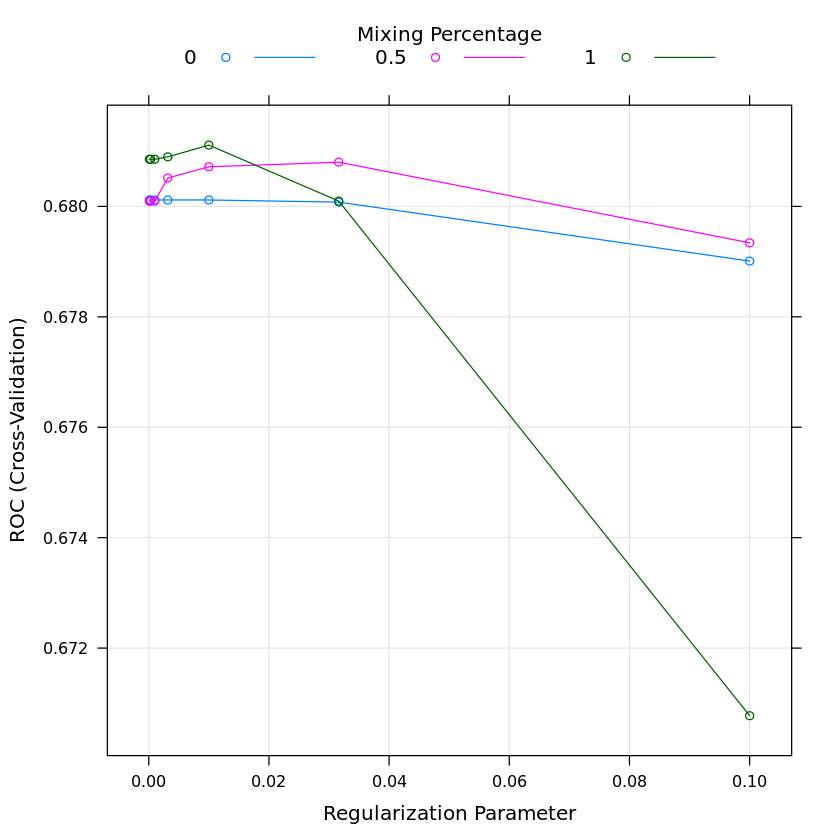

,k
,<int>
38,38


,k,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
38,38,0.6669619,0.5698214,0.6552642,0.0214089,0.03489371,0.04166973


Setting levels: control = No, case = Yes

Setting direction: controls < cases




Call:
roc.default(response = HOLDOUT$Buy, predictor = predict(REG,     newdata = HOLDOUT, type = "prob")$Yes)

Data: predict(REG, newdata = HOLDOUT, type = "prob")$Yes in 635 controls (HOLDOUT$Buy No) < 765 cases (HOLDOUT$Buy Yes).
Area under the curve: 0.6641

Setting levels: control = No, case = Yes

Setting direction: controls < cases




Call:
roc.default(response = HOLDOUT$Buy, predictor = predict(GLMnet,     newdata = HOLDOUT, type = "prob")$Yes)

Data: predict(GLMnet, newdata = HOLDOUT, type = "prob")$Yes in 635 controls (HOLDOUT$Buy No) < 765 cases (HOLDOUT$Buy Yes).
Area under the curve: 0.6649

Setting levels: control = No, case = Yes

Setting direction: controls < cases




Call:
roc.default(response = HOLDOUT$Buy, predictor = predict(KNN,     newdata = HOLDOUT, type = "prob")$Yes)

Data: predict(KNN, newdata = HOLDOUT, type = "prob")$Yes in 635 controls (HOLDOUT$Buy No) < 765 cases (HOLDOUT$Buy Yes).
Area under the curve: 0.6458

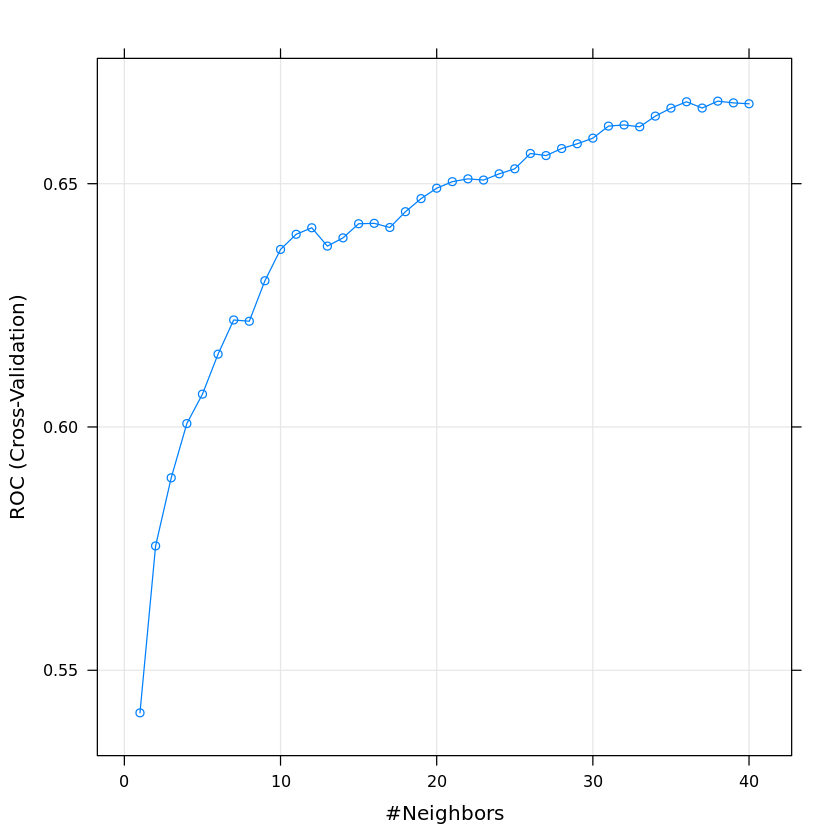

In [29]:
fitControl <- trainControl(method="cv",number=5,classProbs=TRUE,summaryFunction=twoClassSummary)  #do AUC now
set.seed(474); REG <- train(Buy~.,data=TRAIN,method='glm',
                               trControl=fitControl,preProc=c("center", "scale") )
REG$results

glmnetGrid <- expand.grid(alpha = seq(0,1,.5),lambda = 10^seq(-4,-1,by=.5))
set.seed(474); GLMnet <- train(Buy~.,data=TRAIN,method='glmnet', tuneGrid=glmnetGrid,
                               trControl=fitControl, preProc = c("center", "scale"))
plot(GLMnet)
GLMnet$bestTune #Gives best parameters
GLMnet$results[rownames(GLMnet$bestTune),]  #Just the row with the optimal choice of tuning parameter

knnGrid <- expand.grid(k=1:40)
set.seed(474); KNN <- train(Buy~.,data=TRAIN,method='knn', tuneGrid=knnGrid,
                               trControl=fitControl, preProc = c("center", "scale"))
plot(KNN)
KNN$bestTune #Gives best parameters
KNN$results[rownames(KNN$bestTune),]  #Just the row with the optimal choice of tuning parameter

roc(HOLDOUT$Buy,predict(REG,newdata=HOLDOUT,type="prob")$Yes)
roc(HOLDOUT$Buy,predict(GLMnet,newdata=HOLDOUT,type="prob")$Yes)
set.seed(474); roc(HOLDOUT$Buy,predict(KNN,newdata=HOLDOUT,type="prob")$Yes)

**Response:**  There's no signs of overfitting (where the AUC is more than 10% lower where expected).  The two logistic regression models happen to have the highest AUC on this holdout sample.